## Load SAVE dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path
import os
os.chdir('../')

SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan

# SAVE_label = pd.read_csv('data/SAVE/save_household_survey_updates_data_v0-3.csv', index_col = 0)
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)


## 계절별 분석

In [2]:
SAVE_data_dict = dict()

start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-02-15 23:00:00')
SAVE_data_dict['겨울'] = SAVE.loc[start_date:end_date,:]

start_date = pd.to_datetime('2017-04-01 00:00:00')
end_date = pd.to_datetime('2017-05-15 23:00:00')
SAVE_data_dict['봄'] = SAVE.loc[start_date:end_date,:]

start_date = pd.to_datetime('2017-07-01 00:00:00')
end_date = pd.to_datetime('2017-08-15 23:00:00')
SAVE_data_dict['여름'] = SAVE.loc[start_date:end_date,:]


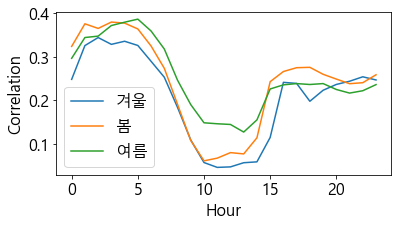

In [19]:
plt.figure(figsize =(6,3))

keys = ['겨울', '봄', '여름']
corr = defaultdict(list)
for key in keys:
    data = SAVE_data_dict[key]
    SAVE_rs, SAVE_id = dim_reduct(data.values, 24 * 4, th = 0)
    SAVE_id = data.columns[SAVE_id]
    SAVE_rs = downsampling(SAVE_rs, 4)

    # matching with label
    i_list = []
    SAVE_label_id_list = []
    for i, id in enumerate(SAVE_id):
        if id[2:] in SAVE_label.index:
            i_list.append(i)
            SAVE_label_id_list.append(id[2:])
    
    SAVE_rs = SAVE_rs[i_list,:]
    SAVE_label_tmp = SAVE_label.loc[SAVE_label_id_list, :]
    SAVE_label_tmp['id'] = SAVE_label_tmp.index
    SAVE_label_tmp.drop_duplicates(subset=['id'], inplace = True, keep='first')

    # nan 제거
    nan_idx = pd.isnull(SAVE_label_tmp['Q2'].values)
    SAVE_rs = SAVE_rs[~nan_idx, :]
    SAVE_label_tmp = SAVE_label_tmp['Q2'].values[~nan_idx]

    for i in range(24):
        corr[key].append(np.corrcoef(SAVE_rs[:,i], SAVE_label_tmp)[0,1])
    plt.plot(corr[key], label = key)

plt.ylabel('Correlation')
plt.xlabel('Hour')
plt.legend()
plt.show()

### * 계절별 대표 부하 확인

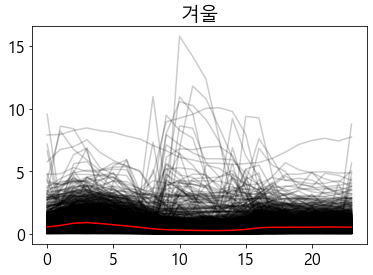

In [20]:
for key in keys:
    data = SAVE_data_dict[key]
    SAVE_rs, SAVE_id = dim_reduct(data.values, 24 * 4, th = 0)
    SAVE_id = data.columns[SAVE_id]
    SAVE_rs = downsampling(SAVE_rs, 4)
    plt.title(key)
    plt.plot(SAVE_rs.T, alpha = 0.2, color = 'k')
    plt.plot(SAVE_rs.mean(axis=0).T, color = 'r')
    plt.show()
    break


### * 시간별 분포 차이

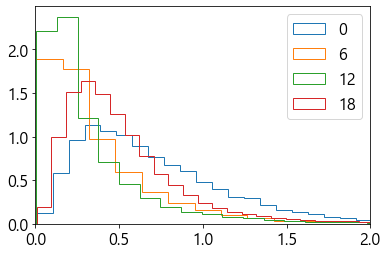

In [25]:
plt.figure()
step = 6
for i in range(0, 24, step):
    plt.hist(SAVE_rs[:,i:i+step].reshape(-1), label = i, bins = 100, alpha = 1,\
         histtype='step', density = True)
plt.xlim(0, 2)
plt.legend()
plt.show()

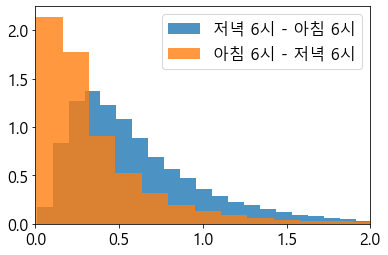

In [23]:
plt.figure()
plt.hist(np.concatenate([SAVE_rs[:,0:6].reshape(-1)] + [SAVE_rs[:,18:].reshape(-1)]), label = '저녁 6시 - 아침 6시', bins = 100, alpha = 0.8,\
         histtype='stepfilled', density = True)
plt.hist(SAVE_rs[:,6:18].reshape(-1), label = '아침 6시 - 저녁 6시', bins = 100, alpha = 0.8,\
         histtype='stepfilled', density = True)
plt.xlim(0, 2)
plt.legend()
plt.show()
 

## Nan 분포 확인

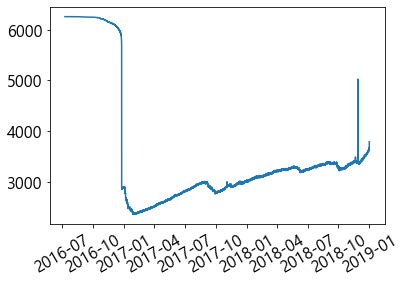

In [24]:
plt.plot(pd.isnull(SAVE).sum(axis=1))
plt.xticks(rotation = 30)
plt.show()


### label id가 겹치는 데이터 조사

In [66]:
helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

### 겹치는 id에 대해 기간 overlap이 있는지 확인

In [96]:
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        invalid_idx_list.append(value)
        if ((~pd.isnull(SAVE[value])).sum(axis=1) >1).sum() > 1:
            print('Overlap exist')

In [100]:
invalid_idx_list[:10]

[['A39000008RC', 'E39000008RC'],
 ['A390004Y2FN', 'I390004Y2FN'],
 ['A3956600053', 'G3956600053'],
 ['A3956600056', 'E3956600056'],
 ['A3956600091', 'I3956600091'],
 ['A3956600176', 'I3956600176'],
 ['A3956600200', 'I3956600200'],
 ['A3956610255', 'E3956610255'],
 ['A3956610335', 'I3956610335'],
 ['A3956610369', 'E3956610369']]

### 겹치는 id끼리 plot
=> 특정 기간별로 나눠졌을 것이라 추측됨

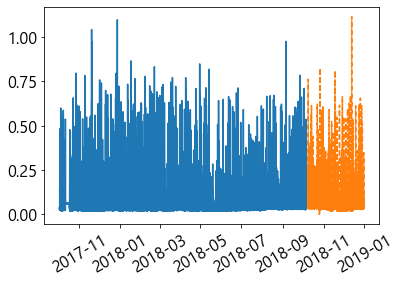

In [98]:
plt.plot(SAVE[invalid_idx_list[0][0]])
plt.plot(SAVE[invalid_idx_list[0][1]], '--')
plt.xticks(rotation = 30)
plt.show()

### 아래와같이 데이터 적은 집들은 제외해야 함

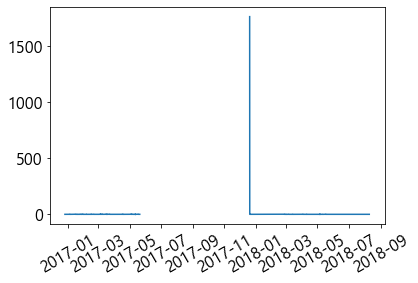

In [93]:
plt.plot(SAVE[value])
plt.xticks(rotation = 30)
plt.show()